In [2]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional

## Task 1: Playing with Pseudo-Randomness

### Part A: Implement and Benchmark an LCG

In [3]:
def linear_congruential_generator(seed: int,
                                  multipler: int,
                                  increment: int,
                                  modulus: int,
                                  sequence_length: Optional[int] = None):
    sequence = [seed]

    if sequence_length is None:
        sequence_length = modulus

    for i in range(sequence_length):
        sequence.append((sequence[-1] * multipler + increment) % modulus)

    return sequence

In [4]:
LCG_PARAMS = [
    # Multiplier, Increment,   Modulus;
    ([         5,         1,      2**6], True),   # Satisfies Hull-Dobell, small space.
    ([         7,         9,        60], False),  # Does not satisfy Hull-Dobell, small space.
    ([        75,         4, 2**16 + 1], True),   # Satisfies Hull-Dobell, large space.
    ([         7,         1,     30030], False),  # Does not satisfy Hull-Dobell, large space.
    ([         5,         7,     2**10], True),   # Satisfies Hull-Dobell, not a good random space(?)
]
"""
A sequence of the LCG parameters we want to feed in - in the order of
(Multiplier, Increment, Modulus), paired with whether they satisfy the
Hull Dobell Theorem.
"""

'\nA sequence of the LCG parameters we want to feed in - in the order of\n(Multiplier, Increment, Modulus), paired with whether they satisfy the\nHull Dobell Theorem.\n'

In [5]:
# We always use seed as 0 and generate 1M entries.
N_ENTRIES = 10**6
lcg_sequences = [
    linear_congruential_generator(0, *(params[0]), N_ENTRIES) for params in LCG_PARAMS
]


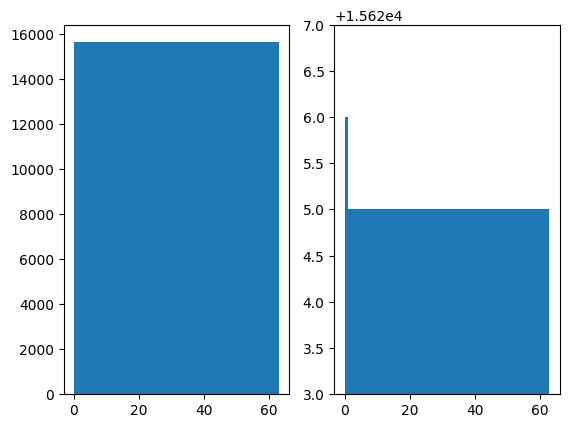

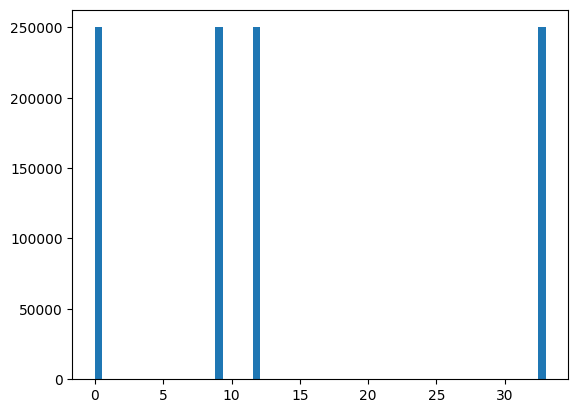

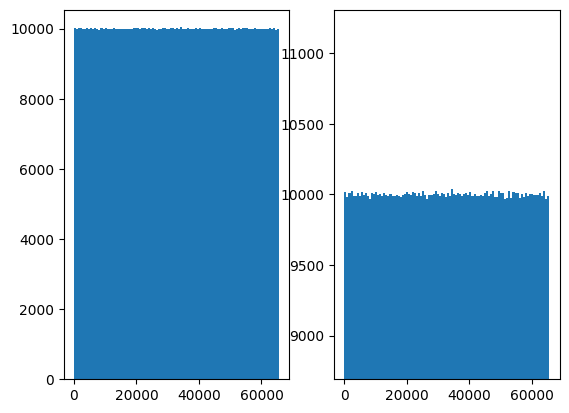

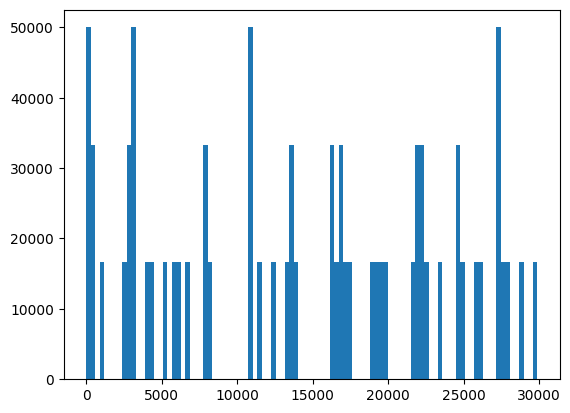

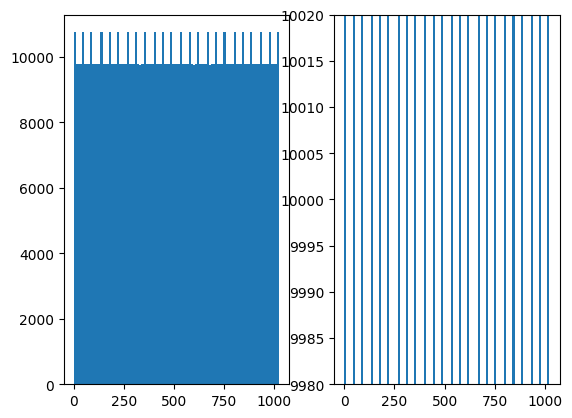

In [6]:
for sequence, params in zip(lcg_sequences, LCG_PARAMS):
    size = params[0][2]
    is_hull_dobell = params[1]
    bin_count = 100 if size > 1000 else size

    if is_hull_dobell:
        # We know that the full sequence will be covered before repeating.
        #
        # But after the first loop, the sequence may enter a smaller loop
        # that only covers a subset of the entire sample space. So basically
        # X_{m+1} need not be X_{0}, and if it is not we enter into a smaller
        # loop.
        #
        # Otherwise, if we cover a full cycle every cycle, then the difference
        # between the counts of two bins cannot exceed the x-range that is
        # covered in one bin. So, to check how good our coverage in later cycles
        # is, we zoom in on the y-axis in these cases.

        expected_occurrences = N_ENTRIES / bin_count
        plt.subplot(1, 2, 1)
        plt.hist(sequence, bins=bin_count)

        plt.subplot(1, 2, 2)
        plt.hist(sequence, bins=bin_count)

        dev = 2 * size // bin_count
        plt.ylim(int(expected_occurrences - dev),
                 int(expected_occurrences + dev))
        plt.show()

    else:
        plt.hist(sequence, bins=bin_count)
        plt.show()



In [7]:
def compute_entropy(rand_array: np.ndarray,
                    elements_to_consider: int,
                    use_shannon: bool = False) -> float:
    """
    Computes the entropy of an array containing the sequential outputs of an
    randomly generated array while only considering the first
    ``elements_to_consider`` elements of the array. Based on the ``use_shannon``
    parameter, this function returns either the Shannon entropy or the Min
    entropy (default).
    """
    rand_array = rand_array[:elements_to_consider]
    random_variable_probabilities = \
        np.unique(rand_array, return_counts=True)[1] / len(rand_array)

    if not use_shannon:
        # Use Min entropy.
        return -np.log2(np.max(random_variable_probabilities))

    return np.sum(random_variable_probabilities * -np.log2(random_variable_probabilities))


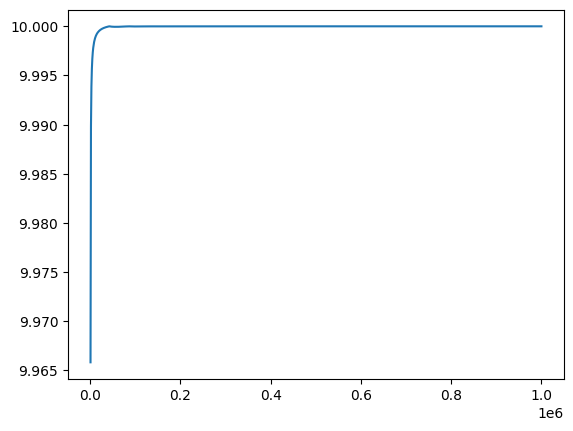

In [8]:
# 1. Choose LCG parameters such that there are no more than 2^10 possible
#    values.
#
# 2. Over a long LCG sequence (at least 10^6 samples), as the generator
#    produces values, treat the sequence of outputs up to each step as a
#    growing empirical distribution.
#
# 3. At regular intervals (e.g., every 1000 iterations), compute the Shannon
#    Entropy or Min-Entropy of the current sample distribution.

def plot_entropy(sequence: np.ndarray, increment: int, use_shannon: bool = False) -> None:
    """
    Plots the entropies of subsequences of the given sequence. The first
    subsequence captures the first ``increment`` elements of the given sequence,
    and each subsequent subsequence captures the next ``increment`` elements of
    the given sequence after the last element covered by its predecessor.

    :param sequence:    The sequence whose step-wise entropy is to be plotted.
    :param increment:   The length of each of the steps.
    :param use_shannon: Whether to use Shannon entropy or the Min entropy (default).
    """
    x_indices = []
    y_indices = []
    for n in range(increment, len(sequence) + 1, increment):
        entropy = compute_entropy(sequence, n, use_shannon=use_shannon)
        x_indices.append(n)
        y_indices.append(entropy)

    plt.plot(x_indices, y_indices)
    plt.show()


INCREMENT = 1000
lcg_output_array = np.array(linear_congruential_generator(seed            = 0,
                                                          multipler       = 5,
                                                          increment       = 1,
                                                          modulus         = 2**10,
                                                          sequence_length = N_ENTRIES))

plot_entropy(lcg_output_array, INCREMENT, use_shannon=True)

### Part B: Implement and Benchmark AES-Based PRNGs

In [9]:
from aes.aes_impl import encrypt_message_aes_cbc

In [10]:
def pad_seed(seed_bytes: bytes, target_len=16) -> bytes:
    """
    A helper function to pad/truncate the given seed to ``target_len`` bytes
    (default 16). Padding is done by adding 0-bytes till we reach the target
    length. Returns the padded seed bytes.
    """
    if len(seed_bytes) > target_len:
        return seed_bytes[:target_len]

    pad_len = target_len - len(seed_bytes)
    return seed_bytes + b'\x00' * pad_len


def aes_pseudo_rng(seed: bytes, num_bytes: int) -> list[bytes]:
    """
    Generates a sequence of pseudo-random bytes using the AES algorithm.

    :param seed: The seed to provide to the AES algorithm.
    :param num_bytes: The number of bytes to generate.

    :return: A list of length-1 byte strings. Each element of this list
             is a pseudo-random byte.
    """
    # One run of the AES generates 16 random bytes, assuming the input length is
    # less than 16 bytes. We will assume that the integers we provide it would
    # be shorter than 16 bytes, since its unlikely that our users will ask for
    # more than 16 * 2^128 bytes to be generated.
    num_iter = num_bytes // 16

    # The AES encryption itself provides the pseudo-randomness, so providing a
    # simple counter is sufficient. Note that this leads to the CTR mode of AES,
    # but we do not use that here.

    # 4 bytes should be enough to cover num_iter, the implementation will pad
    # this ot the needed 16 bytes.
    return [encrypt_message_aes_cbc(i.to_bytes(4), seed)
            for i in range(num_iter)]


In [19]:
SEED_LENGTHS = [1, 2, 8]  # in bytes

# The original example uses 10^7, but that takes a bit too long while prototyping.
# These values can always be edited later once we're done with everything.
SEQUENCE_LENGTHS = [10 ** 5, 3 * 10**5, 10 ** 6]

In [24]:
# Generate and store sequences
all_sequences = {
    seed_len: {
        seq_len: np.array([int.from_bytes(b) for b in
                           aes_pseudo_rng(pad_seed(np.random.bytes(seed_len)),
                                          seq_len)])
        for seq_len in SEQUENCE_LENGTHS
    }
    for seed_len in SEED_LENGTHS
}

Entropy Plot for seed length 1 and sequence length 100000


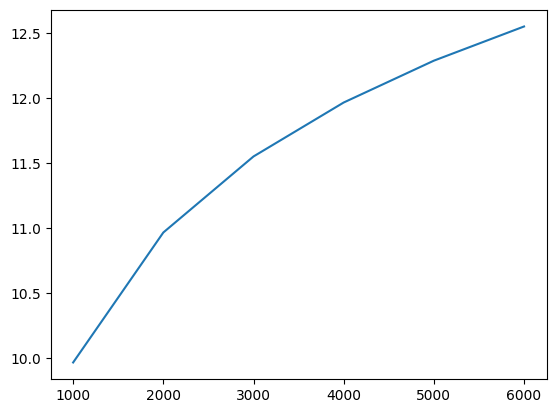

Entropy Plot for seed length 1 and sequence length 300000


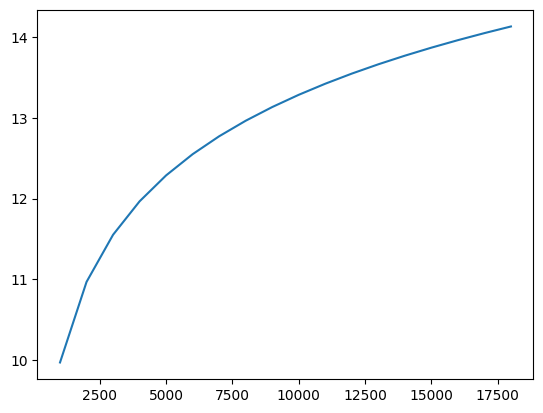

Entropy Plot for seed length 1 and sequence length 1000000


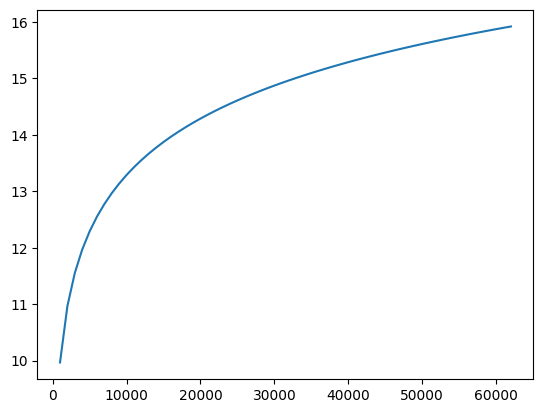

Entropy Plot for seed length 2 and sequence length 100000


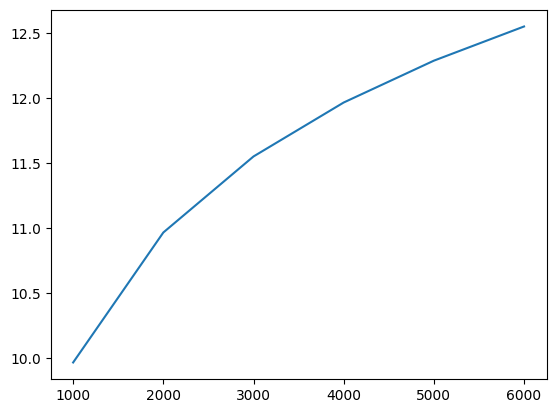

Entropy Plot for seed length 2 and sequence length 300000


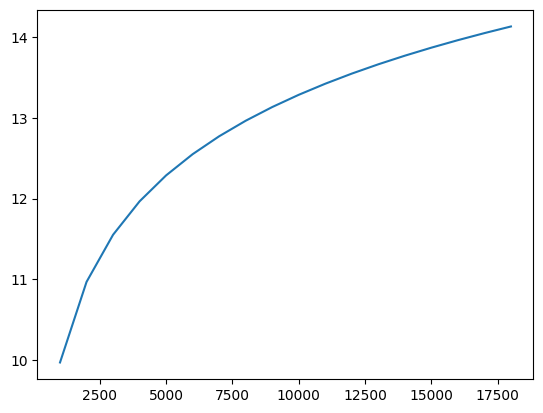

Entropy Plot for seed length 2 and sequence length 1000000


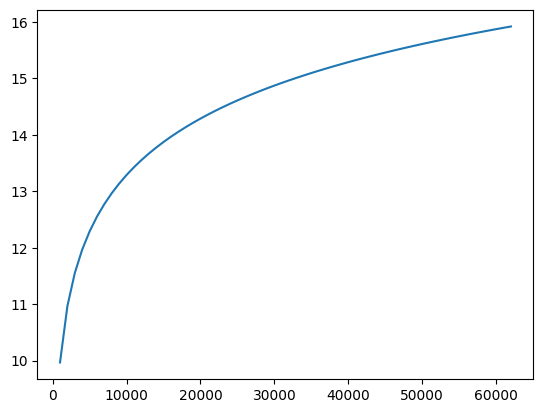

Entropy Plot for seed length 8 and sequence length 100000


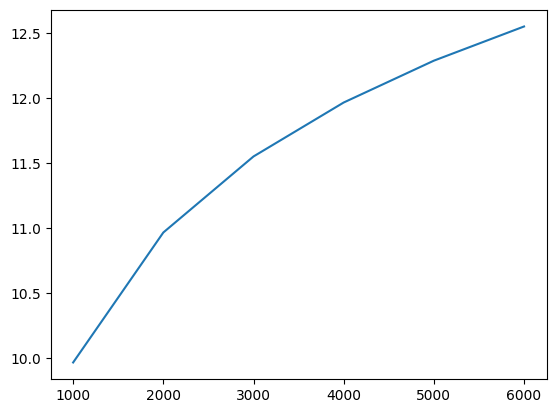

Entropy Plot for seed length 8 and sequence length 300000


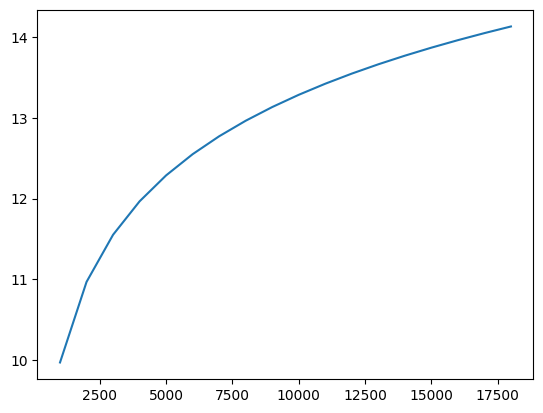

Entropy Plot for seed length 8 and sequence length 1000000


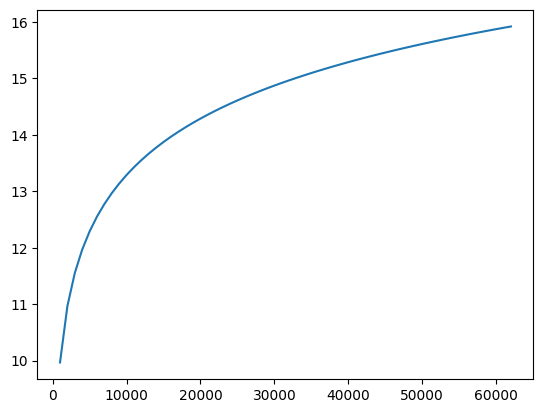

In [25]:
for (seed_len, seq_len_sequences) in all_sequences.items():
    for (seq_len, sequence) in seq_len_sequences.items():
        print(f"Entropy Plot for seed length {seed_len} and sequence length {seq_len}")
        plot_entropy(sequence, INCREMENT, use_shannon=True)


{1: {100000: array([216381515235045597789150401050584554891,
       220391623220930322960627222479916891528,
       168726333325165352715035253692434220062, ...,
       294861896799144361809741464294713451091,
       82242974433382741777492498816994750223,
       289479770239400314954561579454741013257],
      shape=(6250,), dtype=object), 300000: array([149049198528540204227227524089423827890,
       256422073261793215883140514458424679457,
       92404259804521976848415499957630831715, ...,
       49825679540765850757617406432454479472,
       324004598001259350498477857970537909453,
       306929610728432828927959357214085071812],
      shape=(18750,), dtype=object), 1000000: array([19757740728076105086393487264176455368,
       82930212010861721132387938653801021356,
       139394389173739416950835162347167811377, ...,
       259024201908215776709164431134595387363,
       331883202085544403602775495827258816805,
       256407065795547776699263350843235343721],
      shape=(62500,)

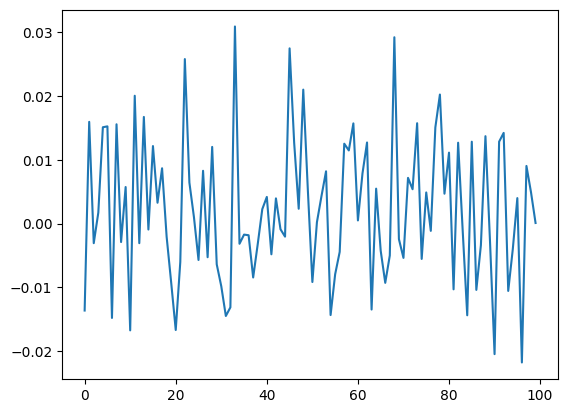

Autocorrelation plot for seed length 1 and sequence length 300000


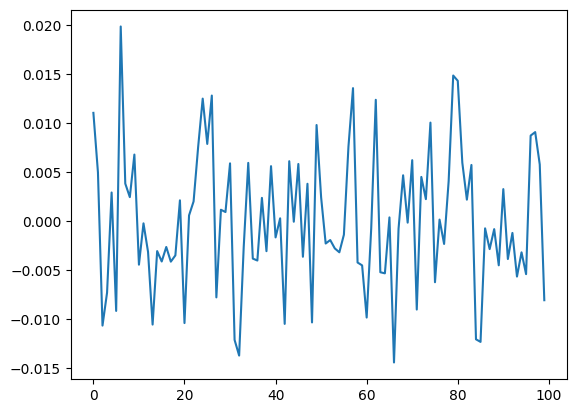

Autocorrelation plot for seed length 1 and sequence length 1000000


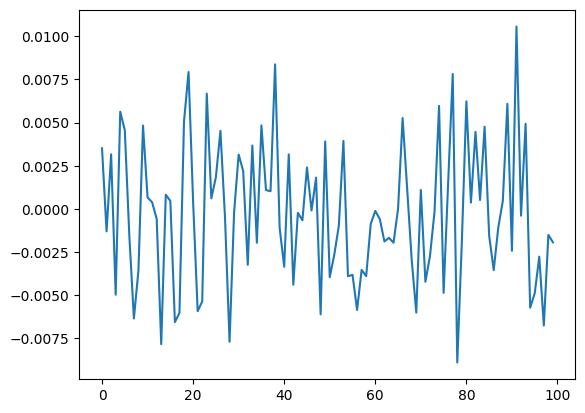

Autocorrelation plot for seed length 2 and sequence length 100000


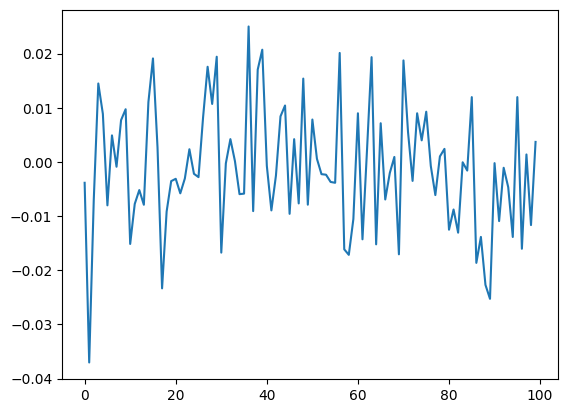

Autocorrelation plot for seed length 2 and sequence length 300000


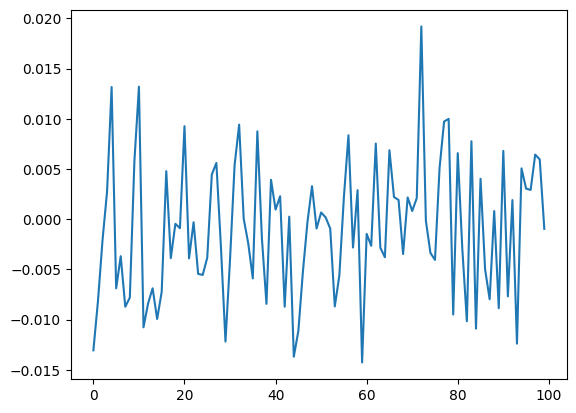

Autocorrelation plot for seed length 2 and sequence length 1000000


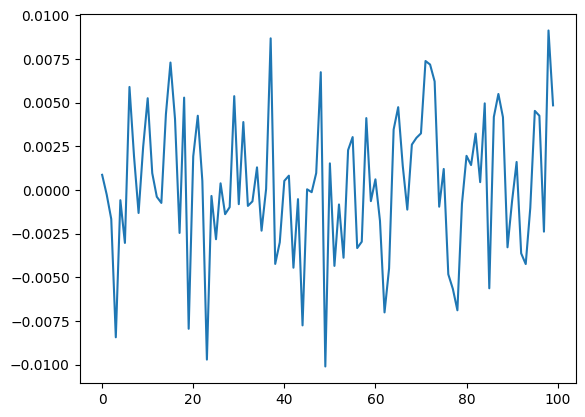

Autocorrelation plot for seed length 8 and sequence length 100000


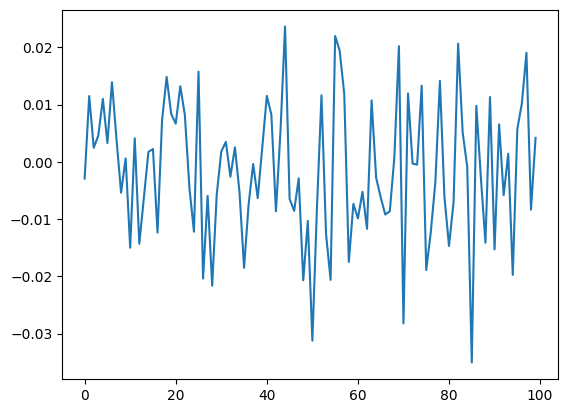

Autocorrelation plot for seed length 8 and sequence length 300000


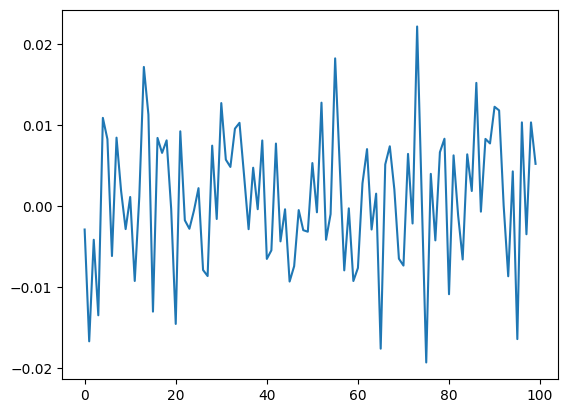

Autocorrelation plot for seed length 8 and sequence length 1000000


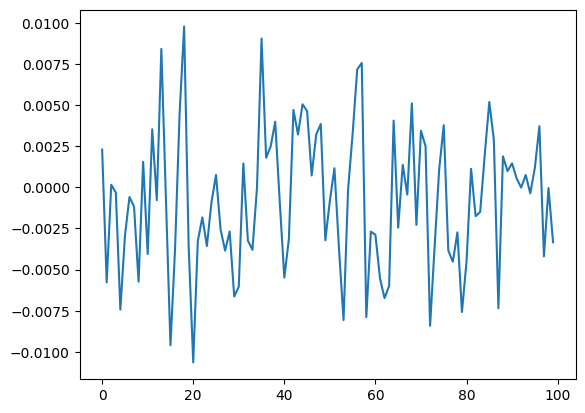

In [27]:
def get_autocorrelation(sequence:np.ndarray, lag):
    """
    Returns the autocorrelation for the given sequence and lag. This is the
    covariance between the sequence and the sequence shifted by lag, with
    respect to the variance of the sequence.
    """
    sequence_avg = np.average(sequence)
    length = len(sequence)
    return (np.dot(sequence[:length-lag] - sequence_avg, sequence[lag:] - sequence_avg)
            / (np.var(sequence) * len(sequence)))


def plot_autocorrelation(sequence, max_lag=100):
    """
    Computes the autocorrelation for the given sequence using lag values from 1
    to max_lag (inclusive) and plots them.
    """
    autocorr_array = np.array([get_autocorrelation(sequence, i) for i in range(1, max_lag+1)])
    plt.plot(autocorr_array)
    plt.show()


for (seed_len, seq_len_sequences) in all_sequences.items():
    for (seq_len, sequence) in seq_len_sequences.items():
        print(f"Autocorrelation plot for seed length {seed_len} and sequence length {seq_len}")
        plot_autocorrelation(sequence)

In [ ]:

# TODO: apply statistical tests (e.g., Chi-squared) to compare with uniform distribution
def run_statistical_tests(sequence):
    pass  # TODO: run and print p-values for randomness tests

### (BONUS) Part C: Breaking the Illusion of Randomness

### Bonus Task:
Train a light-weight model (small-neural net or decision tree) to predict the next number in your random number sequences generated from LCG and AES. Now try implementing at least one other more robust PRNGs from the list below:
- XOR-Shift Generator
- Permuted Congruential Generator (PCG) 
- SplitMix64 

In [ ]:
# You may want to import these packages, though feel free to import anything else you need

# import tensorflow as tf

